In [1]:
import pandas as pd
import scipy.io
import re
import sys
import warnings
import pickle
from nilearn import plotting

In [2]:
from mvpa2.datasets.mri import fmri_dataset
from generic_utils import *

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


ModuleNotFoundError: No module named 'generic_utils'

In [ ]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.

In [ ]:
from mvpa2 import *

In [ ]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [ ]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
results_filepath=ml_data_folderpath + "/SST/mvpa_tt_res_v3_conditions_84subs_twoclasses_pfcmask.pkl"

In [8]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [9]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [10]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [11]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [12]:
for kn in individual_differences.keys():
    print(kn +", " + str(type(individual_differences[kn])))
    print(individual_differences[kn].tolist())


subject, <class 'pandas.core.series.Series'>
['DEV001', 'DEV002', 'DEV004', 'DEV005', 'DEV006', 'DEV007', 'DEV008', 'DEV009', 'DEV010', 'DEV011', 'DEV012', 'DEV013', 'DEV014', 'DEV015', 'DEV016', 'DEV017', 'DEV018', 'DEV019', 'DEV020', 'DEV021', 'DEV022', 'DEV023', 'DEV024', 'DEV025', 'DEV026', 'DEV027', 'DEV028', 'DEV029', 'DEV030', 'DEV031', 'DEV032', 'DEV033', 'DEV034', 'DEV035', 'DEV036', 'DEV037', 'DEV038', 'DEV039', 'DEV040', 'DEV041', 'DEV042', 'DEV043', 'DEV044', 'DEV045', 'DEV046', 'DEV047', 'DEV048', 'DEV049', 'DEV050', 'DEV051', 'DEV052', 'DEV053', 'DEV054', 'DEV055', 'DEV056', 'DEV057', 'DEV058', 'DEV059', 'DEV060', 'DEV061', 'DEV062', 'DEV063', 'DEV064', 'DEV065', 'DEV066', 'DEV067', 'DEV068', 'DEV069', 'DEV070', 'DEV071', 'DEV072', 'DEV073', 'DEV074', 'DEV075', 'DEV076', 'DEV077', 'DEV078', 'DEV079', 'DEV080', 'DEV081', 'DEV082', 'DEV083', 'DEV084', 'DEV085', 'DEV086', 'DEV087', 'DEV088', 'DEV089', 'DEV090', 'DEV091', 'DEV093', 'DEV094', 'DEV095', 'DEV096', 'DEV097', 'DEV

In [13]:
import sys

sys.path.append(os.path.abspath("../../ml/"))

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [14]:
spm_file = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat'
sl_mat = scipy.io.loadmat(
    spm_file,
    simplify_cells=True            
)

#convert from an SPM.mat file into a dataframe list of the betas
beta_dict_list = []
mat_betas = sl_mat['SPM']['Vbeta']
for beta_i in range(len(mat_betas)):
    beta = mat_betas[beta_i]
    b_description = beta['descrip']
    condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)
    if (condition_label is not None):
        beta_dict_list = beta_dict_list + [{
            'condition_index':beta_i,
            'condition_label':condition_label.group(1),
            'raw_beta_description':beta['descrip'],
            'beta':beta['fname']
        }]
#    print(condition_label)
beta_df = pd.DataFrame(beta_dict_list)

#fill in the details related to the subject
beta_df['subject']='DEV005'
beta_df['wave']=1

<>:13: DeprecationWarning: invalid escape sequence \(
<>:13: DeprecationWarning: invalid escape sequence \(
/tmp/ipykernel_19422/122697270.py:13: DeprecationWarning: invalid escape sequence \(
  condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)


In [15]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

In [16]:
import mvpa2.datasets 

In [17]:
import nibabel as nib

In [18]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_2_',
    concatenate_condition_labels=False,
    mask="beta"
)

TypeError: import_beta_series_pymvpa2() got an unexpected keyword argument 'concatenate_condition_labels'

In [ ]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_2_',
    concatenate_condition_labels=False
)

In [34]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:2],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_2subs_correct_cond_.pkl


In [32]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject DEV009. Skipping this subject.
DEV010
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV010/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV014
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV014/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV016/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_10subs_correct_cond.pkl


In [33]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected,'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject DEV009. Skipping this subject.
DEV010
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV010/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV011
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV011/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV014
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV014/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV016/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV018
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV018/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV019
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV019/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV020
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV020/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV021
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV022
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV022/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV023
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV023/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV024
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV024/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV025
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV025/SPM.mat
not enough conditions for subject DEV025. Skipping this subject.
DEV026
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV026/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV027
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV027/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV028
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV028/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV029
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV029/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV030
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV030/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV034
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV034/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV035
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV035/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV036
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV036/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV039
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV040
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV040/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV041
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV041/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV042
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV042/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV043
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV043/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV046
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV046/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV047
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV047/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV048
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV048/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV049
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV049/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV050
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV050/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV051
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV051/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV052
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV052/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV053
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV055
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV055/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV056
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV056/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV057
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV057/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV058
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV058/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV059
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV059/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV060
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV060/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV062
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV062/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV064
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV064/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV067
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV067/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV068
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV068/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV069
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV069/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV071
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV073
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV073/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV074
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV074/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV076
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV076/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV077
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV077/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV079
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV079/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV083
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV083/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV084
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV084/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV085
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV085/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV086
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV086/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV087
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV087/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV089
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV089/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV097
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV105
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV105/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV107
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV107/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV135
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV135/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV141
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV141/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV145
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV145/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV157
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV157/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV158
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV158/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV159
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV159/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV164
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV164/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV169
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV169/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV171
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV171/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV173
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV177
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV177/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV186
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV186/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV197
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV197/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV206
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV206/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV215
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV215/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV216
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV216/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV217
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV217/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV218
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV218/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl


In [102]:
sa_to_df(my_test_data.sa)

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [104]:
my_test_data.shape

(4, 1082035)

In [105]:
sa_to_df(my_test_data.sa)

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [106]:
my_test_data.fa

FeatureAttributesCollection(items=[ArrayCollectable(name='voxel_indices', doc=None, value=array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [ 96, 114,  94],
       [ 96, 114,  95],
       [ 96, 114,  96]]), length=1082035)])

In [110]:
my_test_data.a['get_sa_as_df'] = lambda: sa_to_df(my_test_data.sa)

In [111]:
my_test_data.a.get_sa_as_df()

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [24]:
mask_list = get_all_masks(ml_data_folderpath)

In [25]:
mask_list

,mask_name,mask_filepath,thresh
0,negative affect_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0
1,response inhibition_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0
2,negative emotions_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0
0,harvardoxford-cortical_prob_Superior Frontal G...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
1,harvardoxford-cortical_prob_Frontal Pole,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
2,"harvardoxford-cortical_prob_Cingulate Gyrus, p...",/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
3,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
4,harvardoxford-cortical_prob_Frontal Operculum ...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
5,harvardoxford-cortical_prob_Supramarginal Gyru...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10
6,harvardoxford-cortical_prob_Angular Gyrus,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10


## masks

In [17]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected,'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_' + 'harvardoxford-cortical_prob_Frontal Orbital Cortex',
    concatenate_condition_labels=False,
    mask=mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex']
)

NameError: name 'mask_list' is not defined

In [ ]:
beta_imgpath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii'

In [ ]:
import nibabel as nib

## Getting masked data we can view as a compliant Nifti1Image

### combine the data and mask in nilearn before converting to pymvpa

In [19]:
data_via_nib = nib.concat_images([nib.load(subject_dir + b) for b in ['beta_0001.nii']])
first_img = nib.load(subject_dir + 'beta_0001.nii')
selected_mask = mask_list.loc[3,:]
mask_img_raw = nib.load(selected_mask['mask_filepath'])
mask_img_resampled = resample_img(mask_img_raw,first_img.affine,target_shape = first_img.shape)

NameError: name 'subject_dir' is not defined

In [20]:
selected_mask

NameError: name 'selected_mask' is not defined

In [157]:
#mask_img = compute_brain_mask(mask_img_resampled,threshold=.1)
import nilearn
mask_img = nilearn.image.binarize_img(mask_img_resampled,threshold=10)

In [133]:
from nilearn.masking import apply_mask, compute_brain_mask

In [158]:
masked_image = math_img("img_series * img_mask",img_series=data_via_nib,img_mask = mask_img)

ValueError: ("Input formula couldn't be processed, you provided 'img_series * img_mask',", 'operands could not be broadcast together with shapes (97,115,97,1) (97,115,97) ')

In [18]:
from nilearn.image import math_img

### combine the mask and image 

In [75]:
from nilearn.image import resample_img

In [76]:
mask_list = get_all_masks(ml_data_folderpath)

In [77]:
mask_list

,mask_name,mask_filepath,thresh
0,negative affect_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
1,response inhibition_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
2,negative emotions_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
3,harvardoxford-cortical_prob_Superior Frontal G...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
4,harvardoxford-cortical_prob_Frontal Pole,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
5,"harvardoxford-cortical_prob_Cingulate Gyrus, p...",/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
6,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
7,harvardoxford-cortical_prob_Frontal Operculum ...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
8,harvardoxford-cortical_prob_Supramarginal Gyru...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
9,harvardoxford-cortical_prob_Angular Gyrus,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0


In [78]:
subject_dir = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/'

In [79]:
#nifti_list = [nib.load(subject_dir + b) for b in ['beta_0001.nii','beta_0002.nii']]
filepath_list = [subject_dir + b for b in ['beta_0001.nii','beta_0002.nii']]

In [80]:
first_dataset_img = nib.load(filepath_list[0])

In [81]:
selected_mask = mask_list.loc[1,:]

In [82]:
print(selected_mask['mask_filepath'])
masking_threshold = selected_mask['thresh']
mask_img_raw = nib.load(selected_mask['mask_filepath'])
mask_img_resampled = resample_img(mask_img_raw,first_dataset_img.affine,target_shape = first_dataset_img.shape)
#mask_binarized = (mask_img_resampled.get_fdata()>masking_threshold).astype(float)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/response inhibition_association-test_z_FDR_0.01.nii.gz


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


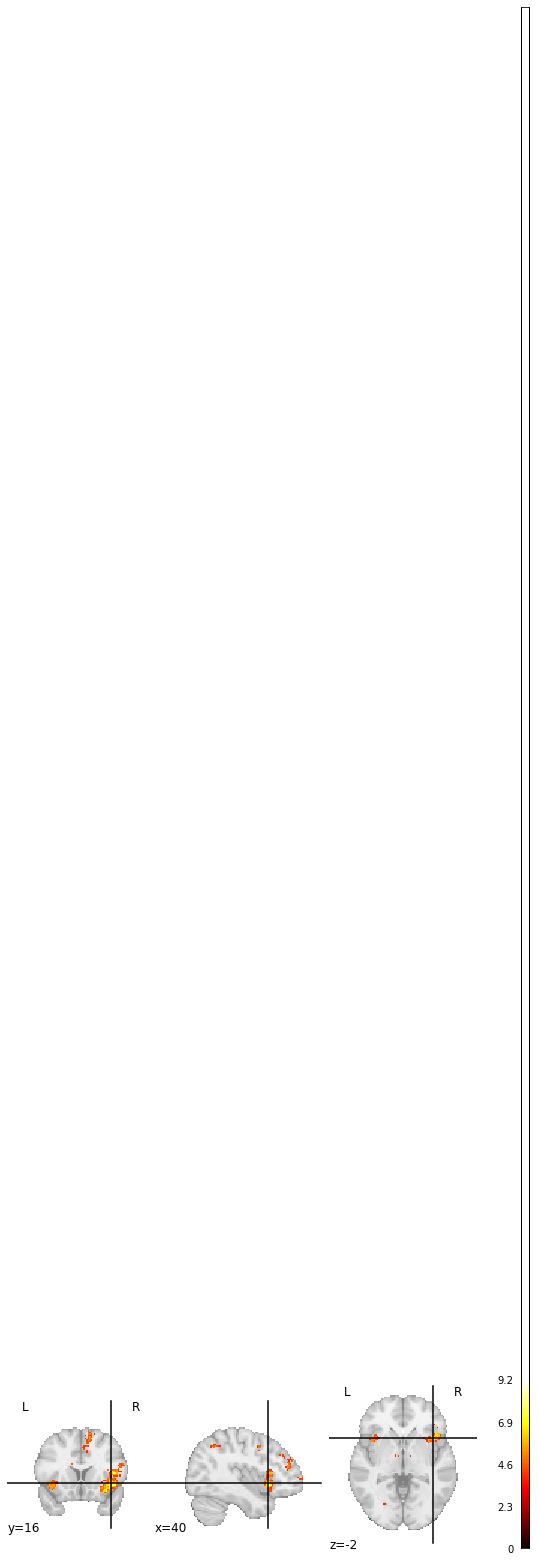

In [83]:
plotting.plot_stat_map(mask_img_raw)

In [84]:
import nilearn

In [85]:
masking_threshold

0.1

In [86]:
nifti_mask_binarized = nilearn.image.binarize_img(mask_img_resampled,0.1)

To get the affine and header, we either have to generate this ourselves, or load the data _separately_ in nib, just to get the header.

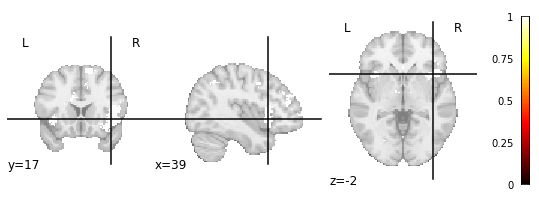

In [87]:
plotting.plot_stat_map(nifti_mask_binarized)

In [88]:
data_via_nib = nib.concat_images(filepath_list)

In [89]:
pymvpa_dataset_masked = fmri_dataset(filepath_list, mask = nifti_mask_binarized)
print(pymvpa_dataset_masked.shape)
pymvpa_dataset_notmasked = fmri_dataset(filepath_list)
print(pymvpa_dataset_notmasked.shape)

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


(2, 2797)
(2, 1082035)


In [90]:
pymvpa_dataset_masked.a['mask_nifti']=nifti_mask_binarized

In [91]:
masked_nifti = nilearn.masking.unmask(pymvpa_dataset_masked.samples,pymvpa_dataset_masked.a['mask_nifti'].value)

In [92]:
# masked_nifti_img = nib.nifti1.Nifti1Image(
#     np.reshape(pymvpa_dataset_masked.samples,data_via_nib.shape),
#     affine= data_via_nib.affine,
#     header=data_via_nib.header)

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


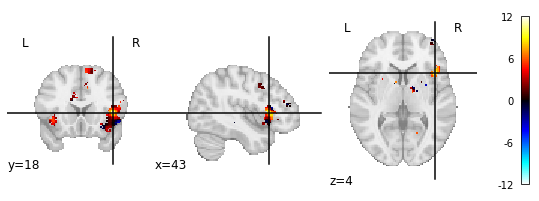

In [93]:
from nilearn import plotting
plotting.plot_stat_map(masked_nifti.slicer[...,0])


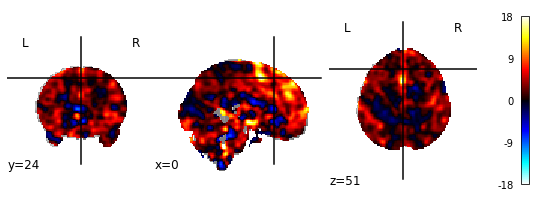

In [94]:
plotting.plot_stat_map(first_dataset_img,vmax=18,cut_coords = (0,24,51))

## now all the other masks

In [1]:
mask_list=get_all_masks(ml_data_folderpath)

NameError: name 'get_all_masks' is not defined

In [27]:
for i, mr in mask_list.iterrows():
    print(mr['mask_name'])
    my_test_data =import_beta_series_pymvpa2(
        train_subjs_selected,'conditions',
        out_folder = ml_data_folderpath + "/SST/",
        conditions_to_include = ['CorrectGo','CorrectStop'],
        condition_count_required=2,
        supplementary_df = individual_differences,
        out_file_suffix = '_correct_cond_' + mr['mask_name'],
        beta_processing_args={
            'spatially_concatenate': False,
            'mask': mr['mask_filepath'],
            'masking_threshold': mr['thresh']
        }
    )

negative affect_association-test_z_FDR_0.01
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/mvpa_pipeline_utils.py:69: DeprecationWarning: invalid escape sequence \(
  condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)


NameError: name 'nilearn' is not defined

In [251]:
my_test_data =import_beta_series_pymvpa2(
        train_subjs_selected[0:2],'conditions',
        out_folder = ml_data_folderpath + "/SST/",
        conditions_to_include = ['CorrectGo','CorrectStop'],
        condition_count_required=2,
        supplementary_df = individual_differences,
        out_file_suffix = '_correct_cond_' + selected_mask['mask_name'],
        beta_processing_args={
            'spatially_concatenate': False,
            'mask': selected_mask['mask_filepath'],
            'masking_threshold': selected_mask['thresh']
        }
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
[[   2.    0.    0.  -96.]
 [   0.    2.    0. -132.]
 [   0.    0.    2.  -78.]
 [   0.    0.    0.    1.]]
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
<class 'nibabel.nifti1.Nifti1Image'>
1072263, 9772,    condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


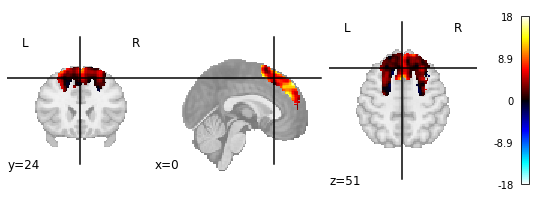

In [255]:
plotting.plot_stat_map(nilearn.masking.unmask(my_test_data.samples[0],my_test_data.a['mask_nifti'].value))
